In [10]:
import pandas as pd
import numpy as np

# KEY VARIABLES
N = 1000 # number of simulations
PLAYER_WEIGHT = 0.90 # % of score based on players
H2H_WEIGHT = 0.10 # % of score based on previous head-to-head
STD = 10 # "randomness" sampled from a normal distribution with standard deviation

# READ DATA
fifa  = pd.read_csv('/home/johnorourke/PycharmProjects/Stuff/DS_for_MS/World_Cup_2022-main/data/players_20.csv')
orgs = pd.read_csv('/home/johnorourke/PycharmProjects/Stuff/DS_for_MS/World_Cup_2022-main/data/organizations.csv')
game_matrix = pd.read_csv('/home/johnorourke/PycharmProjects/Stuff/DS_for_MS/World_Cup_2022-main/data/game_matrix.csv')


In [13]:
# FINDING INTERNATIONAL REPRESENTATION (# players representing a country)
representation = fifa['nationality'].value_counts()

# FILTER COUNTRIES WITH LESS THAN 15 PLAYERS
valid_representation = representation[~(representation < 15)]
invalid_representation = representation[~(representation > 15)]

invalid_list = invalid_representation.index.tolist()
valid_list = valid_representation.index.tolist()
#add Qatar
valid_list.append('Qatar')

for i in valid_list:
    fifa.filter(like=i, axis=0)

In [14]:
print(fifa)

       sofifa_id         short_name nationality  overall player_positions  \
0         158023           L. Messi   Argentina       94       RW, CF, ST   
1          20801  Cristiano Ronaldo    Portugal       93           ST, LW   
2         190871          Neymar Jr      Brazil       92          LW, CAM   
3         200389           J. Oblak    Slovenia       91               GK   
4         183277          E. Hazard     Belgium       91           LW, CF   
...          ...                ...         ...      ...              ...   
18273     245006         Shao Shuai    China PR       48               CB   
18274     250995       Xiao Mingjie    China PR       48               CB   
18275     252332          Zhang Wei    China PR       48               CM   
18276     251110       Wang Haijian    China PR       48               CM   
18277     233449         Pan Ximing    China PR       48               CM   

           work_rate team_position  
0         Medium/Low            RW  
1

In [15]:
# take the top 15 players aveage
d = []

for i in valid_list:
    throw_away_df = fifa.loc[fifa['nationality'] == i]
    mean = throw_away_df.nlargest(n=15, columns=['overall']).mean()
    d.append(
        {
            'Average': mean['overall'],
            'Team': i
        })
team_avg = pd.DataFrame(d)

/tmp/ipykernel_1205638/2657580477.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = throw_away_df.nlargest(n=15, columns=['overall']).mean()
/tmp/ipykernel_1205638/2657580477.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = throw_away_df.nlargest(n=15, columns=['overall']).mean()
/tmp/ipykernel_1205638/2657580477.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = throw_away_df.nlargest(n=15, columns=['overall']).mean()
/tmp/ipykernel_1205638/2657580477.py:6: 

In [16]:
#add an average team score of 50 for Qatar.  They have no ranked players
team_avg['Average'] = team_avg['Average'].fillna(50)

In [17]:
# Define Groups

group_a = ['Qatar',
           'Ecuador',
           'Senegal',
           'Netherlands']
group_b =['England',
          'Iran',
          'USA',
          'Wales']
group_c =['Argentina',
          'Saudi Arabia',
          'Mexico',
          'Poland' ]
group_d =['France',
          'Australia',
          'Denmark',
          'Tunisia' ]
group_e =['Spain',
          'Costa Rica',
          'Germany',
          'Japan']
group_f =['Belgium',
          'Canada',
          'Morocco',
          'Croatia' ]
group_g =['Brazil',
          'Serbia',
          'Switzerland',
          'Cameroon' ]
group_h =['Portugal',
          'Ghana',
          'Uruguay',
          'Korea Republic']

#make a list of each team in the groups
group_list = [group_a, group_b, group_c, group_d, group_e, group_f, group_g, group_h]
teams_to_groups = []
for group in group_list:
    teams_to_groups.append(group)
flat_list = [item for sublist in teams_to_groups for item in sublist]

In [18]:
def value_getter(item):
    return item[1]

def group_stage(group):
    '''
    teams in a group must all play eachother.
    a win is worth 3 points
    a tie is worth 1 point
    loss is worth 0 points

    teams with the largest two scores advance into the elimintaion round.

    :param group: (group of 4 teams)
    :return: two advancing teams
    '''
    #initailze scores as zero in dictionary
    group_scores = {}
    for i in range(len(group_a)):
        group_scores[group[i]] = 0

    #head to head matches
    #make a list of winning teams, ties are stored as tuples of teams
    matches = [ compare_teamz(group[0],group[1]), compare_teamz(group[0],group[2]), compare_teamz(group[0],group[3]),
               compare_teamz(group[1],group[2]), compare_teamz(group[1],group[3]), compare_teamz(group[2],group[3])]

    #allocate points to teams
    for match in matches:
        if type(match) is tuple:
            group_scores[match[0]] += 1
            group_scores[match[1]] += 1
        else:
            group_scores[match] += 3

    #find the two highest scores in the dictionary
    winners = sorted(group_scores.items(), key=value_getter)[-2:]
    first = winners[0][0]
    second = winners[1][0]

    #check for a tie and run a tie breaker in the event of a tie
    return first, second


In [22]:
# FUNCTION TO COMPARE INDIVIDUAL COUNTRIES IN A H2H MATCH
def compare_teamz(country_1,country_2):
    '''
    :param country_1:
    :param country_2:
    :return: winning teams weighted score
    '''
    country_1_ave = team_avg.loc[team_avg['Team']==country_1]
    country_1_ave = country_1_ave['Average']


    country_2_ave = team_avg.loc[team_avg['Team']==country_2]
    country_2_ave = country_2_ave['Average']

    #now find head to head scores. this is super clunky but it works
    holder = game_matrix.iloc[:, 0]
    signal = False

    if country_1 in holder.values and country_2 in holder.values:

        indexer = holder.str.findall(country_2).to_numpy().nonzero()[0]
        country_1_h2h = game_matrix[country_1][indexer].tolist()

        indexer = holder.str.findall(country_1).to_numpy().nonzero()[0]
        country_2_h2h = game_matrix[country_2][indexer].tolist()

        # Case where teams have not played
        check_for_NA = country_2_h2h
        if check_for_NA[0] ==' NA ' :
            signal = True

    else:
        signal = True

    if signal == True:
        country_1_score = PLAYER_WEIGHT *  country_1_ave  + (1 - PLAYER_WEIGHT) * np.random.normal(0,STD, size=1)
        country_2_score = PLAYER_WEIGHT *  country_2_ave  + (1 - PLAYER_WEIGHT) * np.random.normal(0,STD, size=1)

    else:
        country_1_score = PLAYER_WEIGHT *  country_1_ave  + H2H_WEIGHT * float(country_1_h2h[0])  +  H2H_WEIGHT * np.random.normal(0,STD, size=1)
        country_2_score = PLAYER_WEIGHT *  country_2_ave  + H2H_WEIGHT * float(country_2_h2h[0])  +  H2H_WEIGHT * np.random.normal(0,STD, size=1)

    #convert scores in float
    country_1_score = float(country_1_score.tolist()[0])
    country_2_score = float(country_2_score.tolist()[0])

    if country_1_score> country_2_score:
        return country_1
    elif country_1_score == country_2_score:
        return country_2, country_2
    else:
        return country_2

In [23]:
#Group Play
def sim_cup():
    #group play
    group_to_advance = [group_a, group_b, group_c, group_d, group_e, group_f, group_g, group_h]
    teams_to_advance_16 = []
    for group in group_to_advance:
        teams_to_advance_16.append(group_stage(group))

    # Round of 16
    one_16 = compare_teamz(teams_to_advance_16[0][0],teams_to_advance_16[1][1])
    two_16 = compare_teamz(teams_to_advance_16[2][0],teams_to_advance_16[3][1])

    three_16 = compare_teamz(teams_to_advance_16[4][0],teams_to_advance_16[5][1])
    four_16 = compare_teamz(teams_to_advance_16[6][0],teams_to_advance_16[7][1])

    five_16 = compare_teamz(teams_to_advance_16[1][0],teams_to_advance_16[0][1])
    six_16 = compare_teamz(teams_to_advance_16[3][0],teams_to_advance_16[2][1])

    seven_16 = compare_teamz(teams_to_advance_16[5][0],teams_to_advance_16[4][1])
    eight_16 = compare_teamz(teams_to_advance_16[7][0],teams_to_advance_16[6][1])

    # Round of 8
    one_8 = compare_teamz(one_16,two_16)
    two_8 = compare_teamz(three_16,four_16)

    three_8 = compare_teamz(five_16,six_16)
    four_8 = compare_teamz(seven_16, eight_16)

    # Round of 4
    one_4 = compare_teamz(one_8,two_8)
    two_4 = compare_teamz(three_8,four_8)

    #final
    final = compare_teamz(one_4,two_4)
    return final

In [24]:
#Monte Carlo
final_wins = {}
for i in flat_list:
    final_wins[i] = 0

for i in range(N):
    winner = sim_cup()
    final_wins[winner] += 1


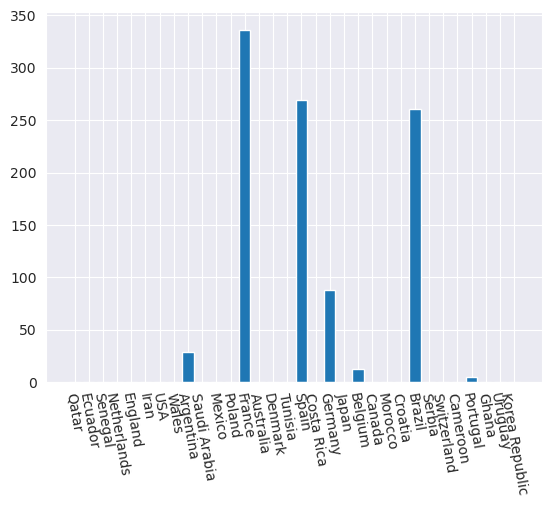

In [25]:
import matplotlib.pyplot as plt
names = final_wins.keys()
values = final_wins.values()
plt.bar(names, values)
plt.xticks(rotation = -80)
plt.show()

In [580]:
winners = sorted(final_wins.items(), key=value_getter)[-12:]
for i in reversed(winners):
    print(i[0])
    print(i[1]/N)
    print(" ")

France
0.352
 
Brazil
0.255
 
Spain
0.248
 
Germany
0.108
 
Belgium
0.016
 
Argentina
0.016
 
Portugal
0.005
 
Korea Republic
0.0
 
Uruguay
0.0
 
Ghana
0.0
 
Cameroon
0.0
 
Switzerland
0.0
 


In [606]:
for i in range(100):
    print(np.random.poisson(4, size=1))

[5]
[2]
[5]
[5]
[4]
[3]
[0]
[6]
[4]
[2]
[1]
[5]
[5]
[2]
[5]
[7]
[5]
[5]
[6]
[6]
[0]
[4]
[5]
[5]
[1]
[8]
[7]
[0]
[10]
[6]
[2]
[3]
[3]
[7]
[8]
[7]
[4]
[5]
[5]
[5]
[4]
[6]
[3]
[1]
[4]
[2]
[2]
[5]
[10]
[7]
[4]
[4]
[3]
[3]
[4]
[4]
[7]
[3]
[4]
[6]
[5]
[4]
[2]
[6]
[2]
[7]
[8]
[2]
[2]
[4]
[10]
[5]
[3]
[3]
[3]
[5]
[3]
[1]
[4]
[4]
[4]
[5]
[2]
[3]
[6]
[6]
[5]
[0]
[2]
[6]
[7]
[7]
[3]
[5]
[4]
[7]
[6]
[7]
[7]
[4]


In [605]:
for i in range(100):
    print(np.random.normal(0, size=1))

[-0.31448455]
[-0.11169966]
[2.09091981]
[0.2002443]
[-0.07362241]
[-0.98145205]
[-0.15989404]
[-0.94659245]
[-1.29416315]
[-0.40023733]
[0.6647219]
[-0.99973269]
[-1.249271]
[-0.20410359]
[-0.84354098]
[-0.21308373]
[0.03771765]
[0.65611876]
[-0.16754827]
[-0.15543614]
[0.24435387]
[0.77793527]
[-0.74962778]
[0.4705192]
[-0.02446708]
[0.03927313]
[0.64744956]
[-1.49738394]
[2.03126911]
[-0.78474631]
[-1.21460042]
[0.01715213]
[-1.83241071]
[-1.30127487]
[0.32380412]
[-0.52938385]
[1.40314974]
[-0.04359487]
[-0.84732705]
[2.20040097]
[-0.64763527]
[-0.4312043]
[-0.52388026]
[0.16276839]
[-0.60853719]
[-1.34864693]
[1.41667655]
[0.45560265]
[0.42095964]
[-1.71234298]
[-0.60216757]
[0.2500881]
[-1.34364258]
[0.30984012]
[0.59641508]
[0.04507507]
[0.98576281]
[-0.07775781]
[-1.50299435]
[-1.64975204]
[-0.59447124]
[-0.44529481]
[-0.21005786]
[0.62504977]
[-0.87115664]
[-0.55500613]
[1.06861736]
[1.46481988]
[-0.61896959]
[-0.53205654]
[0.00966043]
[0.32165929]
[1.44534903]
[0.08154949]
[-